<a href="https://colab.research.google.com/github/BakJungHo/PaCO/blob/main/%ED%95%B4%EC%BB%A4%ED%86%A4/RNN%2BLSTM_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconf

In [2]:
# import matplotlib.pyplot as plt

# plt.rc('font', family='NanumBarunGothic') 

In [3]:
# !pip install yfinance

In [129]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

In [130]:
df2 = pd.read_csv('/content/drive/MyDrive/Finance data/종전외개기.csv')

In [131]:
df2.set_index('날짜', inplace=True)

In [132]:
df2

종가  전월대비 등락률  외국인순매수  개인순매수  기관순매수
날짜                                                     
2005-01-01   932.700012  0.041053    8538  -9523    984
2005-02-01  1011.359985  0.084336   14654  -5725  -8928
2005-03-01   965.679993 -0.045167  -20741   3820  16920
2005-04-01   911.299988 -0.056313   -3243   2291    955
2005-05-01   970.210022  0.064644    1048 -18304  17254
...                 ...       ...     ...    ...    ...
2021-12-01  2977.649902  0.048834   15250 -30452   8397
2022-01-01  2663.340088 -0.105556    -389  12674 -16297
2022-02-01  2699.179932  0.013457   -6207 -10135   -980
2022-03-01  2757.649902  0.021662  -23373  -3604   1769
2022-04-01  2704.709961 -0.022700  -19037   7021 -19430

[208 rows x 5 columns]

In [133]:
window_size = 10 
data_size = 5

def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

[[0.999999999958078, 0.6953489944419763, 0.5262313573125068, 0.6419381738033207, 0.5295093171442202], [0.960442417728603, 0.5415451440046547, 0.25814429544198675, 0.2604532729759657, 0.445896234948393], [0.9591637749547909, 0.6154628169122561, 0.3349375443870703, 0.3783131812490644, 0.5520433392962871], [0.9044764906490511, 0.5090819848438574, 0.5610310398123732, 0.6286854488048295, 0.3194665004921709], [0.8633341405728053, 0.5325771485116438, 0.3749926891420186, 0.3733843588058053, 0.509357348181288], [0.8081354196272882, 0.49960327267826155, 0.6058403308680237, 0.7374620287081758, 0.4553038374168741], [0.8662560946710653, 0.7484609206073531, 0.6384927100299632, 0.036214187861045605, 0.6589844613738929], [0.7344909998690349, 0.3360263366692966, 0.5078247065208608, 0.6783906129002942, 0.41078859026633685], [0.7495157944896718, 0.6539551722098836, 0.45921376947782994, 0.33874858538278224, 0.5647375721143338], [0.7740276006073844, 0.6758748830476675, 0.3157872749297608, 0.435999761748114

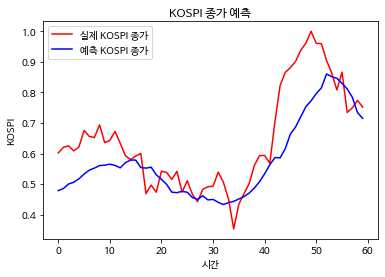

 2022 5월 KOSPI 예측 : [2571.9985] 포인트
 2022 6월 KOSPI 예측 : [2616.0393] 포인트
 2022 7월 KOSPI 예측 : [2823.3818] 포인트
 2022 8월 KOSPI 예측 : [2942.366] 포인트
 2022 9월 KOSPI 예측 : [2851.336] 포인트


In [135]:
dfx = df2[['종가','전월대비 등락률','외국인순매수','개인순매수', '기관순매수']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['종가']]

x = dfx.values.tolist()
y = dfy.values.tolist()

data_x = []
data_y = []
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_x.append(_x)
    data_y.append(_y)
print(_x, "->", _y)

train_size = int(len(data_y) * 0.7)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])

# 모델 생성
model = Sequential()
model.add(LSTM(units=10, activation='relu', return_sequences=True, input_shape=(window_size, data_size)))
model.add(Dropout(0.1))
model.add(LSTM(units=10, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_x, train_y, epochs=60, batch_size=30)
pred_y = model.predict(test_x)

# Visualising the results
plt.figure()
plt.plot(test_y, color='red', label='실제 KOSPI 종가')
plt.plot(pred_y, color='blue', label='예측 KOSPI 종가')
plt.title('KOSPI 종가 예측')
plt.xlabel('시간')
plt.ylabel('KOSPI')
plt.legend()
plt.show()

# df.close[-1] : dfy.close[-1] = x : pred_y[-1]
print(" 2022 5월 KOSPI 예측 :", df2.종가[-1] * pred_y[-1] / dfy.종가[-1], '포인트')
print(" 2022 6월 KOSPI 예측 :", df2.종가[-2] * pred_y[-2] / dfy.종가[-2], '포인트')
print(" 2022 7월 KOSPI 예측 :", df2.종가[-3] * pred_y[-3] / dfy.종가[-3], '포인트')
print(" 2022 8월 KOSPI 예측 :", df2.종가[-4] * pred_y[-4] / dfy.종가[-4], '포인트')
print(" 2022 9월 KOSPI 예측 :", df2.종가[-5] * pred_y[-5] / dfy.종가[-5], '포인트')